# Find Similar  Cell Lines
author: Andrew E. Davidson, aedavids@ucsc.edu

Once we have trained a Low Rank Matrix Factorization model, we expect cell lines that are similar to be closer together. Keep in mind, we know how many features where learned. We do not know what they mean.

In [1]:
import logging
from   setupLogging import setupLogging
configFilePath = setupLogging( default_path='src/test/logging.test.ini.json')
logger = logging.getLogger("notebook")
logger.info("using logging configuration file:{}".format(configFilePath))

from   DEMETER2.lowRankMatrixFactorizationEasyOfUse \
            import LowRankMatrixFactorizationEasyOfUse as LrmfEoU

import igraph as ig
import louvain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import umap

[INFO <ipython-input-1-dbbeabfaed92>:5 - <module>()] using logging configuration file:src/test/logging.test.ini.json


In [2]:
dataDir = "data/"
dataFileName = "D2_Achilles_gene_dep_scores.tsv"
numFeatures = 19
geneFilterPercent = 0.25 
holdOutPercent = 0.40 
easyOfUse = LrmfEoU(dataDir, dataFileName, numFeatures, geneFilterPercent, holdOutPercent)

In [3]:
resultsDict = easyOfUse.loadAll()

In [4]:
# clean tidy version of demeter data
Y, R, cellLinesNames, geneNames, = resultsDict["DEMETER2"]
geneDependencies = Y
print("geneDependencies.shape:{}".format(geneDependencies.shape))

# trained model
# scipy.optimize.OptimizeResult
X, Theta, optimizeResult = resultsDict["LowRankMatrixFactorizationModel"]
genesLRMF = X
print("genesLRMF.shape:{}".format(genesLRMF.shape))
cellLinesLRMF = Theta
print("cellLinesLRMF.shape:{}".format(cellLinesLRMF.shape))

# knockout logical filters. Use to select Train, Validations, and Test values from Y
RTrain, RValidation, RTest = resultsDict["filters"]

geneDependencies.shape:(11193, 501)
genesLRMF.shape:(11193, 19)
cellLinesLRMF.shape:(501, 19)


# Cell Lines
use disease for labels. Would probably be better to use tissue type, or some other meta data

In [5]:
print(cellLinesNames[0:5])
print(cellLinesNames.shape)

['"143B_BONE"' '"22RV1_PROSTATE"' '"2313287_STOMACH"'
 '"697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"' '"769P_KIDNEY"']
(501,)


In [6]:
sampleInfoDF = pd.read_csv("data/sample_info.csv")
sampleInfoDF.head()

,CCLE_ID,disease,disease_subtype,disease_sub_subtype,in_DRIVE,in_Achilles,in_Marcotte,Novartis_name,Novartis_Primary_site,Novartis_Pathologist_Annotation,Marcotte_name,Marcotte_subtype_three_receptor,Marcotte_subtype_neve,Marcotte_subtype_intrinsic
0,127399_SOFT_TISSUE,soft_tissue,synovial_sarcoma,NaN,True,False,False,127399,soft_tissue,Soft_Tissue:Sarcoma_Synovial,NaN,NaN,NaN,NaN
1,1321N1_CENTRAL_NERVOUS_SYSTEM,central_nervous_system,glioma,astrocytoma,True,False,False,1321n1,central_nervous_system,CNS:Glioma,NaN,NaN,NaN,NaN
2,143B_BONE,bone,osteosarcoma,NaN,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,184A1_BREAST,breast,NaN,NaN,False,False,True,NaN,NaN,NaN,184a1,TNBC,basalb,Normal
4,184B5_BREAST,breast,NaN,NaN,False,False,True,NaN,NaN,NaN,184b5,TNBC,basalb,Normal


In [7]:
# check to make sure we will select the disease column in the same order as the cellLineName

#pd.set_option('display.max_rows', None)
cleanCellLinesNames = [ c.replace('"', '') for c in cellLinesNames ] 
selectRows = sampleInfoDF['CCLE_ID'].isin( set(cleanCellLinesNames) )

orderTestSeries = sampleInfoDF.loc[selectRows, ['CCLE_ID']]

print( len(cleanCellLinesNames) )
print(orderTestSeries.count())
print(orderTestSeries.head())

orderTestValues = [v[0] for v in orderTestSeries.values]

# matches is a logical vector. There must be a better way to do this
n = len(cleanCellLinesNames)
matches = [False] * n
for i in range(n):
    if cleanCellLinesNames[i] == orderTestValues[i] :
        matches[i] = True
    
print( sum(matches) )
assert len(cleanCellLinesNames) ==  sum(matches)


501
CCLE_ID    501
dtype: int64
                                  CCLE_ID
2                               143B_BONE
5                          22RV1_PROSTATE
6                         2313287_STOMACH
8  697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
9                             769P_KIDNEY
501


In [8]:
# get labels
diseaseLabelSeries = sampleInfoDF.loc[selectRows, ['disease']]
diseaseLabels = [v[0] for v in diseaseLabelSeries.values]
print("len(diseaseLabels):{}".format(len(diseaseLabels)))

len(diseaseLabels):501


## Cell Lines Low Rank Matrix Nearest Neighbors

In [9]:
k = 4
cellLinesLRMF_Nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(cellLinesLRMF)
cellLinesLRMF_Distances, cellLinesLRMF_Indices = cellLinesLRMF_Nbrs.kneighbors(cellLinesLRMF)
cellLinesLRMF_Graph = cellLinesLRMF_Nbrs.kneighbors_graph(cellLinesLRMF).toarray()

## Descriptive distance stats

In [10]:
nnCellLineLRMFDistDF = pd.DataFrame(data=cellLinesLRMF_Distances)
nnCellLineLRMFDistDF.head()

,0,1,2,3
0,0.0,0.681160,0.702470,0.711966
1,0.0,0.628728,0.706225,0.726107
2,0.0,0.509097,0.517209,0.628728
3,0.0,0.813634,0.840740,0.932602
4,0.0,0.659218,0.732477,0.746334


In [11]:
nnCellLineLRMFDistDF.describe()

,0,1,2,3
count,501.0,501.000000,501.000000,501.000000
mean,0.0,0.820346,0.897555,0.939364
std,0.0,0.245917,0.247199,0.249973
min,0.0,0.446906,0.495185,0.514152
25%,0.0,0.666180,0.748388,0.781254
50%,0.0,0.779850,0.861926,0.916350
75%,0.0,0.929299,1.012788,1.054656
max,0.0,4.017428,4.204574,4.246878


## <span style="color:red">AEDWIP refactor findNearestGenes into python </span>

In [12]:
def findNearestGenes(geneNames, distances, indices, closestN=5):
    '''
    genes that are cloest, nearest, should be more similar
    
    example:
        geneNbrs = NearestNeighbors(n_neighbors=k, algorithm='brute').fit(genes)
        geneDistances, geneIndices = geneNbrs.kneighbors(genes)
    
    arguments:
        distances:
            a 2 d numpy array 
            
        indices
        
    returns 
        (names, smallestDistanceIdxList distance)
            name: 
                a list of tuples of gene names pairs that are close
                
            smallestDistanceIdxList: 
                a list of tuples. values are index into distances matrix
                
            distance, the distance between genes
                
    '''
    cols = 0
    sortedIdx = np.argsort(distances[:,1], axis=cols)
    smallestDistanceIdxList = [ (i, indices[i,1]) for i in sortedIdx[0:closestN] ]
    names = [ (geneNames[i], geneNames[j])  for i,j in smallestDistanceIdxList ]
    distValues = [ distances[i,1] for i in sortedIdx[0:closestN]]

    return (names, smallestDistanceIdxList, distValues)

In [13]:
result = findNearestGenes(cellLinesNames, cellLinesLRMF_Distances, cellLinesLRMF_Indices, closestN=25)
similarCellLines, smallestDistanceIdxList, distValues = result
print("similar genes:\n{}".format(similarCellLines))
print("\n distances:\n{}".format(distValues))

similar genes:
[('"HPAC_PANCREAS"', '"NCIH2023_LUNG"'), ('"NCIH2023_LUNG"', '"HPAC_PANCREAS"'), ('"KYSE140_OESOPHAGUS"', '"TE6_OESOPHAGUS"'), ('"TE6_OESOPHAGUS"', '"KYSE140_OESOPHAGUS"'), ('"SNU601_STOMACH"', '"RKO_LARGE_INTESTINE"'), ('"RKO_LARGE_INTESTINE"', '"SNU601_STOMACH"'), ('"KE39_STOMACH"', '"TE6_OESOPHAGUS"'), ('"NCIH3122_LUNG"', '"KE39_STOMACH"'), ('"NCIH1355_LUNG"', '"HUPT3_PANCREAS"'), ('"HUPT3_PANCREAS"', '"NCIH1355_LUNG"'), ('"CJM_SKIN"', '"TE10_OESOPHAGUS"'), ('"TE10_OESOPHAGUS"', '"CJM_SKIN"'), ('"HCC2218_BREAST"', '"ZR7530_BREAST"'), ('"ZR7530_BREAST"', '"HCC2218_BREAST"'), ('"2313287_STOMACH"', '"SNU601_STOMACH"'), ('"COLO205_LARGE_INTESTINE"', '"KE39_STOMACH"'), ('"NCIH1944_LUNG"', '"2313287_STOMACH"'), ('"UACC257_SKIN"', '"COLO829_SKIN"'), ('"COLO829_SKIN"', '"UACC257_SKIN"'), ('"HCC1806_BREAST"', '"CJM_SKIN"'), ('"KATOIII_STOMACH"', '"NCIH2405_LUNG"'), ('"NCIH2405_LUNG"', '"KATOIII_STOMACH"'), ('"OVCAR4_OVARY"', '"EFE184_ENDOMETRIUM"'), ('"EFE184_ENDOMETRIUM"', '"

## UMAP scatter plot of Cell Lines Low Rank Matrix Nearest Neighbors

In [14]:
nnReducer = umap.UMAP()
nnEmbedding = nnReducer.fit_transform(cellLinesLRMF_Distances)
print("nnEmbedding.shape:{}".format(nnEmbedding.shape))

nnEmbedding.shape:(501, 2)


In [15]:
# #, c=[sns.color_palette()[x] for x in geneEmbedding.target]
# fig= plt.figure(figsize=(12,15))
# ax = plt.gca()

# plt.scatter(nnEmbedding[:, 0], nnEmbedding[:, 1])
# ax.set_aspect('equal', 'datalim')

# plt.title('UMAP projection: Nearest Neighbors of Cell Lines Low Rank Matrix with 19 learned features', fontsize=14);

# # Turn off tick labels
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# plt.show
# fig.savefig('imgs/UMAP_nearestNeighborsCellLines_LMRF19.pdf')

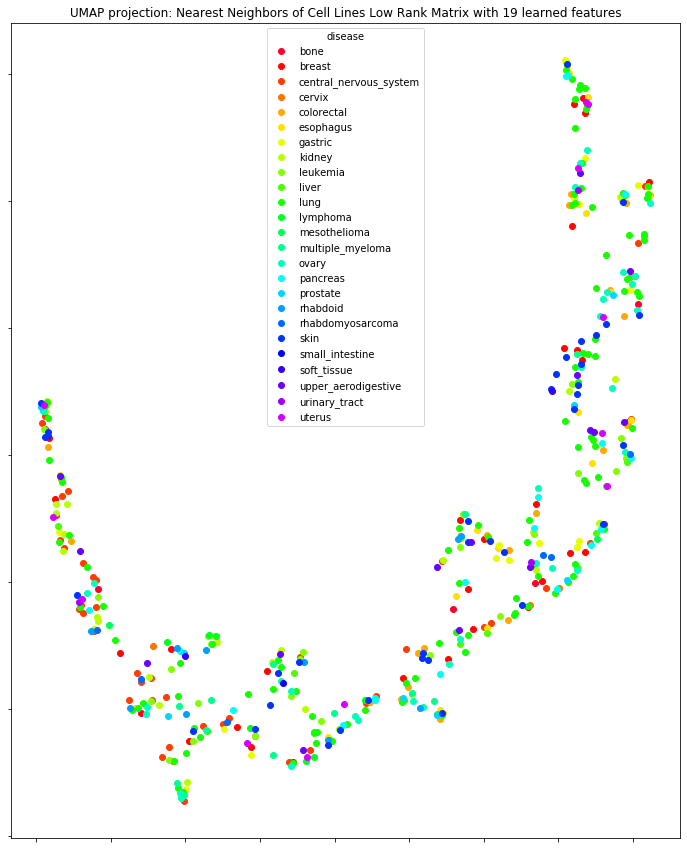

In [16]:
# https://stackoverflow.com/a/21655256
df = pd.DataFrame(dict(x=nnEmbedding[:, 0],
                       y=nnEmbedding[:, 1],
                       label=diseaseLabels))

groups = df.groupby('label')

fig= plt.figure(figsize=(12,15))
ax = plt.gca()
kinds = len(set(diseaseLabels))

plt.title('UMAP projection: Nearest Neighbors of Cell Lines Low Rank Matrix with 19 learned features')
# https://stackoverflow.com/a/8391452
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/kinds) for i in range(kinds)])

for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name ) 
        
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.legend( title="disease" )

plt.show()
fig.savefig('imgs/UMAP_nearestNeighborsCellLines_LMRF19.pdf')

## Cell Line Low Rank Matrix Nearest Neighbors Louvain Clustering

In [17]:
# create a graph
cellLineLRMFGraph = ig.Graph()

# add vertices
numVertices = cellLinesLRMF_Distances.shape[0]
cellLineLRMFGraph.add_vertices(numVertices)

# add edges
for i in range(numVertices):
    idx = cellLinesLRMF_Indices[i,1:]
    edges = [ (i, j) for j in idx ]
    cellLineLRMFGraph.add_edges( edges )

In [18]:
cellLineLRMF_Partition = louvain.find_partition(cellLineLRMFGraph, louvain.ModularityVertexPartition);

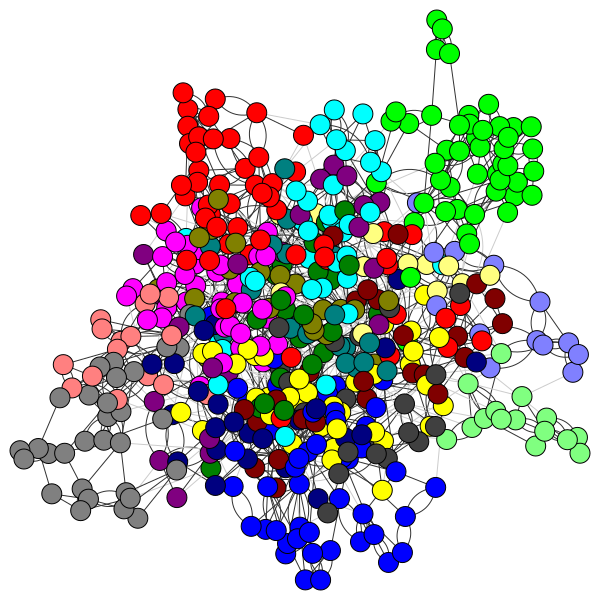

In [19]:
# you can save or display but not both
# only png format is supported
#
# cellLineLRMF_Partition_PlotOut = ig.plot(cellLineLRMF_Partition) 
# cellLineLRMF_Partition_PlotOut.save("imgs/louvain_Nearest_Neigbors_cellLines_LRMF19.png")

ig.plot(cellLineLRMF_Partition) 

## UMap Cell Line Low Rank Matrix Factorization 19 learned features

In [21]:
cellLineLMRF_Reducer = umap.UMAP()
cellLineLMRF_Embedding = cellLineLMRF_Reducer.fit_transform(cellLinesLRMF)
print("CellLineLMRF_Embedding.shape:{}".format(cellLineLMRF_Embedding.shape))

CellLineLMRF_Embedding.shape:(501, 2)


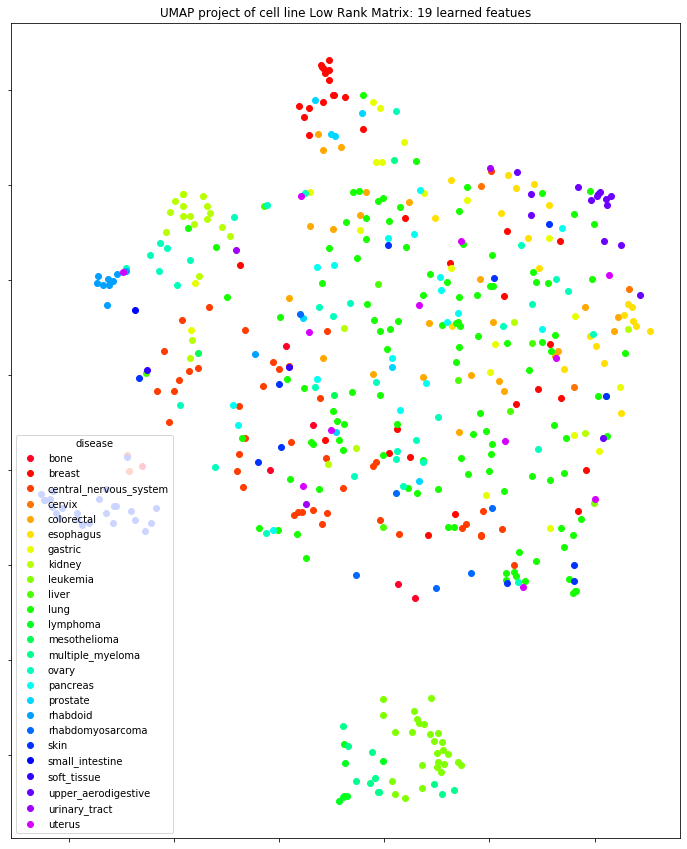

In [22]:
# https://stackoverflow.com/a/21655256
df = pd.DataFrame(dict(x=cellLineLMRF_Embedding[:, 0],
                       y=cellLineLMRF_Embedding[:, 1],
                       label=diseaseLabels))

groups = df.groupby('label')

fig= plt.figure(figsize=(12,15))
ax = plt.gca()
kinds = len(set(diseaseLabels))

plt.title('UMAP project of cell line Low Rank Matrix: 19 learned featues')
# https://stackoverflow.com/a/8391452
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/kinds) for i in range(kinds)])

for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name ) 
        
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.legend( title="disease" )

plt.show()
fig.savefig('imgs/UMAP_cellLine_LMRF19.pdf')

# UMap on original Gene Dependency Data

In [23]:
aedwip why are we doing gen stuff switch to cell
geneDepReducer = umap.UMAP()
geneDepTranspose = np.transpose(geneDependencies)
geneDepEmbedding = geneDepReducer.fit_transform(geneDepTranspose)
print("geneDepEmbedding.shape:{}".format(geneDepEmbedding.shape))

/Users/andrewdavidson/anaconda3/envs/labRotation3TensorFlow/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


geneDepEmbedding.shape:(501, 2)


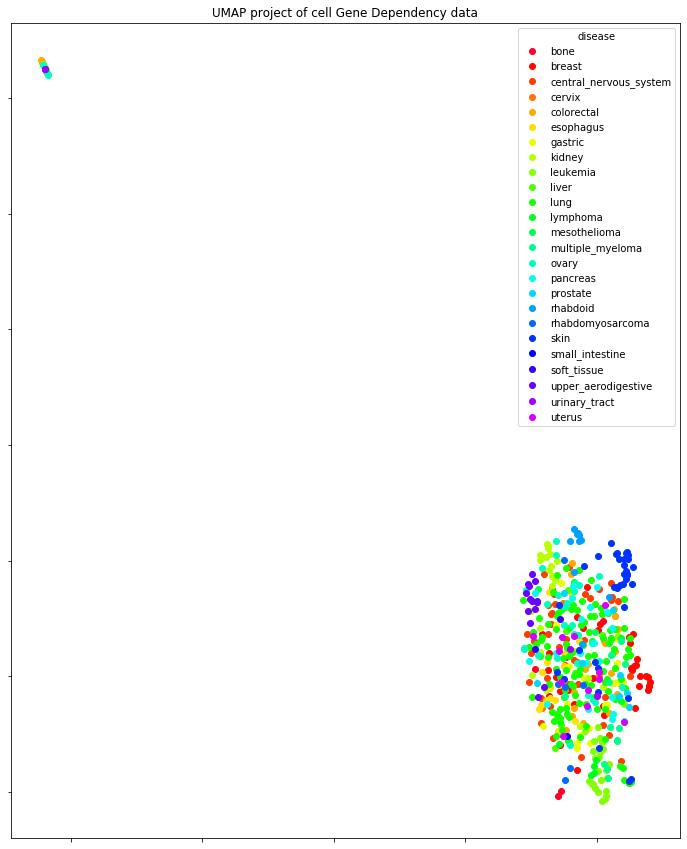

In [28]:
# https://stackoverflow.com/a/21655256
gdeDF = pd.DataFrame(dict(x=geneDepEmbedding[:, 0],
                       y=geneDepEmbedding[:, 1],
                       label=diseaseLabels))

groups = gdeDF.groupby('label')

fig= plt.figure(figsize=(12,15))
ax = plt.gca()
kinds = len(set(diseaseLabels))

plt.title('UMAP project of cell Gene Dependency data')
# https://stackoverflow.com/a/8391452
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/kinds) for i in range(kinds)])

for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name ) 
        
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])

ax.legend( title="disease" )

plt.show()
fig.savefig('imgs/UMAP_GeneDependency_disease.pdf')